# 1D Three Phase Simulation of Alloys and PINN model development 


This notebook contains the simulation of 1D Phase change of aluminium alloy. There will be three phases (solid,liquid and mushy).   

The approach used is finite difference method and the physics involved in heat conduction.

## Import Libraries

In [229]:
import sys
import math
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
import csv
from sklearn import svm
import pandas as pd
import itertools

from ht_simNy import sim1d



from pyDOE2 import fullfact
from pyDOE2 import fracfact

import statsmodels.api as sm

from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
import seaborn as sns
from scipy import stats


### <center>Pareto analysis</center>

<p style="font-size:12px; font-family:'Times New Roman', sans-serif; line-height:1.6;">

In this section sensitivity study of the soldification is performed with respect to different material properties and  initial/boundary conditions. The soldification time is the variable under study and it is calcualted based on solution of 1D heat transfer and phase change equation.



Here the parameters/factors are as follows:-

1. Density for material in liquid state $\rho_l$.<br>
2. Density for material in solid state $\rho_s$.<br>
3. Latent Heat of Fusion <br>
4. Specific heat of material in liquid state $C_{pl}$ <br>
5. Specific heat of material in solid state $C_{ps}$ <br>
6. Thermal Conductivity of material in liquid state $k_l$<br>
7. Thermal Conductivity of material in solid state $k_s$ <br>


Boundary conditions:-
8. Surrounding Temperature <br>

Initial Conditions:-

9. Initial_temperature <br>


</p>




The number of runs are large so a fractional factorial design is adopted.

## Fractional Factorial Design

In [230]:
#Create a fractional factorial design

from pyDOE2 import fracfact

num_levels = 2
levels = [0, 1]
num_vars = 11
design2 = fracfact('a b c d e f g abc abd ace bcf cde')
L_level = 0.99
R_level = 1.01
perc_change = [0.03, 0.03, 0.03, 0.03, 0.03, 0.03, 0.3, 0.03, 0.60, 0.30,0.30]


factor_levels = {
    'rho_l': [2386.20, 2533.8], #A
    'rho_s': [2628.70, 2791.3], #B
    'k_l': [100.88, 107.2],    #C
    'k_s': [93.31,99.08],      #D
    'cp_l': [1207.94, 1282.65], #E
    'cp_s': [934.11, 991.89],  #F
    'Surr_temp': [285.0,298.0], #G
    'L_fusion': [377330,400670], #H
    'temp_init': [901.0, 925.0], # J
    'heat_transfer_coefficient_left': [10.0, 15.0], #K
    'heat_transfer_coefficient_right': [10.0, 15.0], #L
    'Length': [10.0e-3, 20.0e-3],      #M
}


factor_names = list(factor_levels.keys())
# print (313.0 *(1+perc_change[6]))
# Create a DataFrame from the fractional factorial design
doe_df_sol_time_fracfact = pd.DataFrame(design2, columns=factor_names)

for factor, levels in factor_levels.items():
    doe_df_sol_time_fracfact[factor] = doe_df_sol_time_fracfact[factor].map({-1: levels[0], 1: levels[1]})
   
    
print(doe_df_sol_time_fracfact.shape)

(128, 12)


In [231]:
FracFact_doe_sol_time = doe_df_sol_time_fracfact.copy()

FracFact_doe_sol_time['Lowest_Niyama'] = [0.0] * FracFact_doe_sol_time.shape[0] # Data frame inclduing the response variable

print(FracFact_doe_sol_time.shape)



(128, 13)


In [232]:
for i in range(FracFact_doe_sol_time.shape[0]):
    input_values = FracFact_doe_sol_time.iloc[i,:-1].values
    if input_values.size > 0:
        k = sim1d(*input_values)
        FracFact_doe_sol_time.at[i, 'Lowest_Niyama'] = k
        

    

(23531, 48)
Lowest Niyama:2.94, rho_l:2386.2, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:10.0,htc_r:10.0,length:0.01
(21428, 48)
Lowest Niyama:1.61, rho_l:2533.8, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:15.0,htc_r:10.0,length:0.01
(20116, 48)
Lowest Niyama:0.39, rho_l:2386.2, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:10.0,htc_r:15.0,length:0.01
(15933, 48)
Lowest Niyama:3.38, rho_l:2533.8, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.01
(8431, 48)
Lowest Niyama:6.21, rho_l:2386.2, rho_s:2628.7, k_l:107.2, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.02
(10353, 48)
Lowest Niyama:0.01, rho_l

KeyboardInterrupt: 

In [ ]:
FracFact_doe_sol_time.to_csv('FracFact_doe_sol_time.csv', index=False)

### Histogram of the Total Solidifcation time is plotted

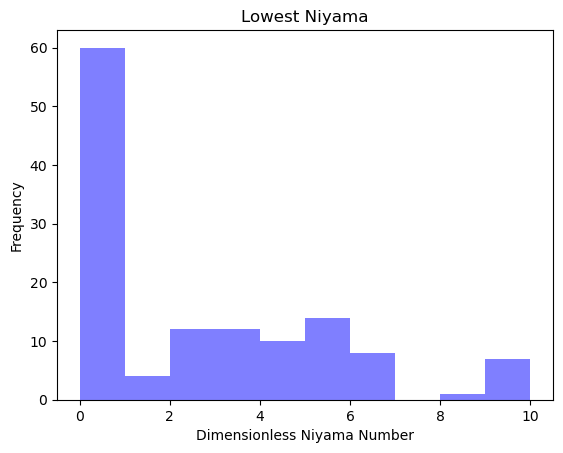

In [ ]:
plt.hist(FracFact_doe_sol_time['Lowest_Niyama'], bins=10, alpha=0.5, color='b')
plt.title('Lowest Niyama')
plt.xlabel('Dimensionless Niyama Number')
plt.ylabel('Frequency')
plt.show()

### Regression model is developed

In [ ]:


# Create the formula for the ANOVA
formula = 'Lowest_Niyama ~ C(rho_l) + C(rho_s) + C(k_l) + C(k_s) + \
           C(cp_l) + C(cp_s) + C(Surr_temp) + C(L_fusion) \
         + C(temp_init)+ C(heat_transfer_coefficient_left) + C(heat_transfer_coefficient_right)+ C(Length) \
         + C(rho_l):C(k_s) + C(rho_s):C(cp_l) + C(k_l):C(cp_s) + C(Surr_temp):C(L_fusion) + \
              C(temp_init):C(heat_transfer_coefficient_right) + C(heat_transfer_coefficient_left):C(Length)'

# Fit the model
model = sm.OLS.from_formula(formula, data=FracFact_doe_sol_time).fit()
print(model.summary())


                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.130
Model:                            OLS   Adj. R-squared:                 -0.004
Method:                 Least Squares   F-statistic:                    0.9702
Date:                Mon, 16 Sep 2024   Prob (F-statistic):              0.496
Time:                        10:02:04   Log-Likelihood:                -303.21
No. Observations:                 128   AIC:                             642.4
Df Residuals:                     110   BIC:                             693.8
Df Model:                          17                                         
Covariance Type:            nonrobust                                         
                                                                       coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------

### Plot of Residuals

The plots of the residuals vs. fitted values are shown below


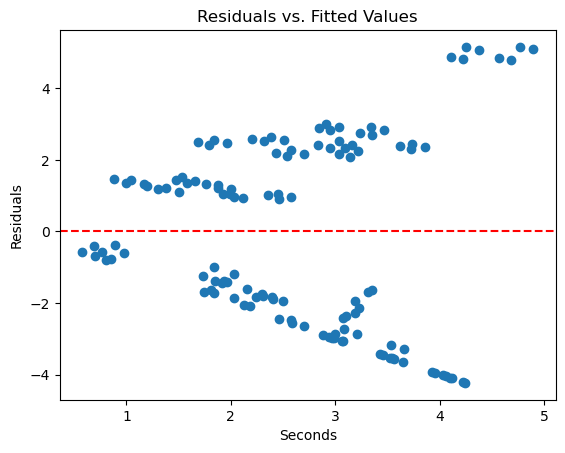

In [ ]:
residuals_ols = model.resid
FracFact_doe_sol_time['Residuals'] =residuals_ols
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model.fittedvalues, residuals_ols)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Seconds')
plt.ylabel('Residuals')
plt.show()


# print (f"This is followed by the histogram of the residuals")
# plt.hist(residuals_ols, bins=10, alpha=0.5, color='b')
# plt.title('Residuals Histogram')
# plt.xlabel('Seconds')
# plt.ylabel('Frequency')
# plt.show()

### Normality of Residuals check

In [ ]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(residuals_ols)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')


Shapiro-Wilk Test Statistic: 0.9399480265740712
p-value: 2.3859648770099305e-05
The residuals are not normally distributed (reject H0).


The interaction was observed among rho_l and cp_s , rho_s and cp_s , cp_l and cp_s  & cp_s and temp_init.

## Center points check

In [ ]:
num_center_points = 1

center_point = {factor: np.mean(levels) for factor,levels in factor_levels.items()}

center_pt_df = pd.DataFrame([center_point] * num_center_points, columns=factor_names)

doe_center_pt = pd.concat([doe_df_sol_time_fracfact, center_pt_df], ignore_index=True)
print(doe_center_pt.iloc[-1:])

      rho_l   rho_s     k_l     k_s      cp_l   cp_s  Surr_temp  L_fusion  \
128  2460.0  2710.0  104.04  96.195  1245.295  963.0      291.5  389000.0   

     temp_init  heat_transfer_coefficient_left  \
128      913.0                            12.5   

     heat_transfer_coefficient_right  Length  
128                             12.5   0.015  


### Factorial design

In [ ]:
Fractional_Factorial_doe_center_pt = doe_center_pt.copy()

Fractional_Factorial_doe_center_pt['Lowest_Niyama'] = [0.0] * Fractional_Factorial_doe_center_pt.shape[0]

print(Fractional_Factorial_doe_center_pt.shape)

(129, 13)


In [ ]:
for i in range(Fractional_Factorial_doe_center_pt.shape[0]):
    input_values = Fractional_Factorial_doe_center_pt.iloc[i,:-1].values
    k= sim1d(*input_values)
    Fractional_Factorial_doe_center_pt.at[i, 'Lowest_Niyama'] = k

    

(23531, 48)
Lowest Niyama:2.94, rho_l:2386.2, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:10.0,htc_r:10.0,length:0.01
(21428, 48)
Lowest Niyama:1.61, rho_l:2533.8, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:15.0,htc_r:10.0,length:0.01
(20116, 48)
Lowest Niyama:0.39, rho_l:2386.2, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:10.0,htc_r:15.0,length:0.01
(15933, 48)
Lowest Niyama:3.38, rho_l:2533.8, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.01
(8431, 48)
Lowest Niyama:6.21, rho_l:2386.2, rho_s:2628.7, k_l:107.2, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.02
(10353, 48)
Lowest Niyama:0.01, rho_l

CSV file generator

In [ ]:
print(Fractional_Factorial_doe_center_pt.head())

    rho_l   rho_s     k_l    k_s     cp_l    cp_s  Surr_temp  L_fusion  \
0  2386.2  2628.7  100.88  93.31  1207.94  934.11      285.0  377330.0   
1  2533.8  2628.7  100.88  93.31  1207.94  934.11      285.0  400670.0   
2  2386.2  2791.3  100.88  93.31  1207.94  934.11      285.0  400670.0   
3  2533.8  2791.3  100.88  93.31  1207.94  934.11      285.0  377330.0   
4  2386.2  2628.7  107.20  93.31  1207.94  934.11      285.0  400670.0   

   temp_init  heat_transfer_coefficient_left  heat_transfer_coefficient_right  \
0      901.0                            10.0                             10.0   
1      925.0                            15.0                             10.0   
2      925.0                            10.0                             15.0   
3      901.0                            15.0                             15.0   
4      901.0                            15.0                             15.0   

   Length  Lowest_Niyama  
0    0.01           2.94  
1    0.01     

### Plot

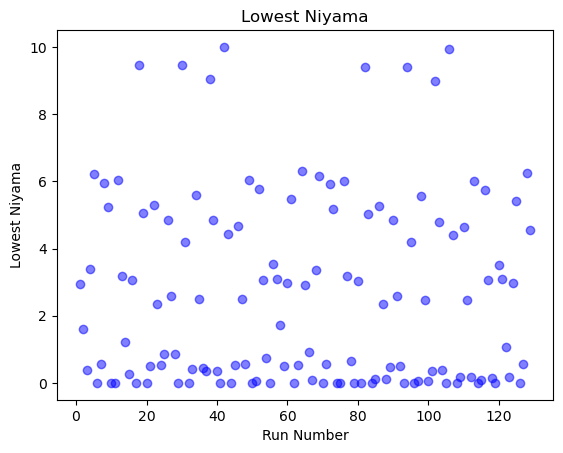

In [ ]:
counts = range(1,len(Fractional_Factorial_doe_center_pt)+1)

plt.scatter(counts,Fractional_Factorial_doe_center_pt['Lowest_Niyama'], alpha=0.5, color='b')
plt.title('Lowest Niyama')
plt.xlabel('Run Number')
plt.ylabel('Lowest Niyama')
plt.show()

### Regression Model

In [ ]:
formula5 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s \
             + cp_l + cp_s + Surr_temp + L_fusion + temp_init + \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
            rho_l*rho_s + rho_l*k_l + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*heat_transfer_coefficient_left + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
            rho_s*cp_s + rho_s*Surr_temp + rho_s*L_fusion  + rho_s*heat_transfer_coefficient_left + \
            rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*cp_l  + k_l*Surr_temp + k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + k_l*Length + k_s*cp_l  + \
            k_s*Surr_temp + k_s*heat_transfer_coefficient_left +  \
            cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*heat_transfer_coefficient_left + \
            cp_l*Length +  cp_s*L_fusion + cp_s*temp_init + cp_s*heat_transfer_coefficient_left + cp_s*heat_transfer_coefficient_right + \
            cp_s*Length + Surr_temp*L_fusion + Surr_temp*temp_init + Surr_temp*heat_transfer_coefficient_left +  \
            Surr_temp*Length + L_fusion*heat_transfer_coefficient_left + L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
            heat_transfer_coefficient_left*Length + heat_transfer_coefficient_right*Length'

model5 = sm.OLS.from_formula(formula5, data=Fractional_Factorial_doe_center_pt.iloc[:-1]).fit()
print(model5.summary())

                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.845
Model:                            OLS   Adj. R-squared:                  0.763
Method:                 Least Squares   F-statistic:                     10.27
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           1.88e-19
Time:                        10:10:21   Log-Likelihood:                -192.90
No. Observations:                 128   AIC:                             475.8
Df Residuals:                      83   BIC:                             604.1
Df Model:                          44                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [ ]:
# Extracting coefficients (terms) and their p-values
terms = model5.params.index
coefficients = model5.params.values
p_values = model5.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.9
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] > p_value_threshold]
print(significant_terms) 

                                        Term   P-Value
6                                       cp_s  0.910827
7                                  Surr_temp  0.983844
20                              rho_l:Length  0.914005
23                                rho_s:cp_s  0.972011
24                           rho_s:Surr_temp  0.909988
27     rho_s:heat_transfer_coefficient_right  0.945089
30                             k_l:Surr_temp  0.980302
35                             k_s:Surr_temp  0.991704
38                            cp_l:Surr_temp  0.985485
41       cp_l:heat_transfer_coefficient_left  0.910111
46      cp_s:heat_transfer_coefficient_right  0.931904
48                        Surr_temp:L_fusion  0.974082
49                       Surr_temp:temp_init  0.987559
50  Surr_temp:heat_transfer_coefficient_left  0.975119
54                           L_fusion:Length  0.905686


In [289]:
formula55 = 'Lowest_Niyama ~ rho_l +rho_s +  heat_transfer_coefficient_left + heat_transfer_coefficient_right +  \
            rho_l*rho_s  \
             +  \
             heat_transfer_coefficient_left*heat_transfer_coefficient_right \
            '

In [290]:

model55 = sm.OLS.from_formula(formula55, data=Fractional_Factorial_doe_center_pt.iloc[:-1]).fit()
print(model55.summary())

                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.779
Model:                            OLS   Adj. R-squared:                  0.768
Method:                 Least Squares   F-statistic:                     71.14
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           2.46e-37
Time:                        10:29:03   Log-Likelihood:                -215.50
No. Observations:                 128   AIC:                             445.0
Df Residuals:                     121   BIC:                             465.0
Df Model:                           6                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [291]:
# Extracting coefficients (terms) and their p-values
terms = model55.params.index
coefficients = model55.params.values
p_values = model55.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.05
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] > p_value_threshold]
print(significant_terms) 

        Term   P-Value
0  Intercept  0.081391


The plots of the residuals vs. fitted values are shown below


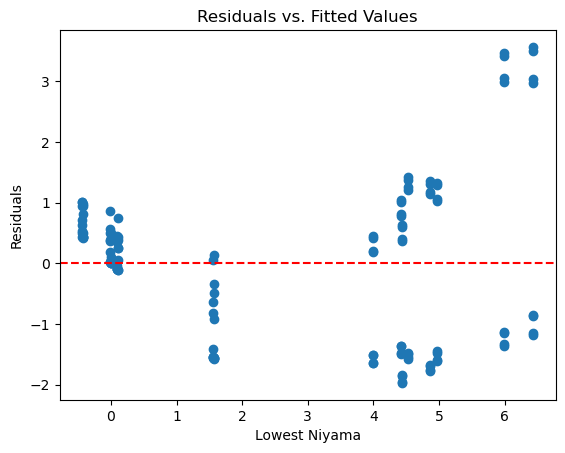

In [293]:
resid55 = model55.resid
Fractional_Factorial_doe_center_pt['Residuals'] = resid55
print (f"The plots of the residuals vs. fitted values are shown below")
# Plot residuals vs. fitted values
plt.scatter(model55.fittedvalues, resid55)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residuals vs. Fitted Values')
plt.xlabel('Lowest Niyama')
plt.ylabel('Residuals')
plt.show()

In [298]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(resid55)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')

Shapiro-Wilk Test Statistic: 0.918629589637915
p-value: 1.019515036602472e-06
The residuals are not normally distributed (reject H0).


### Anova Table

In [295]:
anova_table = sm.stats.anova_lm(model55, typ=2)
print(anova_table)

                                                        sum_sq     df  \
rho_l                                                35.659013    1.0   
rho_s                                                28.275200    1.0   
heat_transfer_coefficient_left                        1.474903    1.0   
heat_transfer_coefficient_right                       1.706628    1.0   
rho_l:rho_s                                           8.673612    1.0   
heat_transfer_coefficient_left:heat_transfer_co...  690.804450    1.0   
Residual                                            217.322544  121.0   

                                                             F        PR(>F)  
rho_l                                                19.854086  1.878019e-05  
rho_s                                                15.742956  1.234401e-04  
heat_transfer_coefficient_left                        0.821191  3.666332e-01  
heat_transfer_coefficient_right                       0.950210  3.316107e-01  
rho_l:rho_s         

#### Main effects with center points

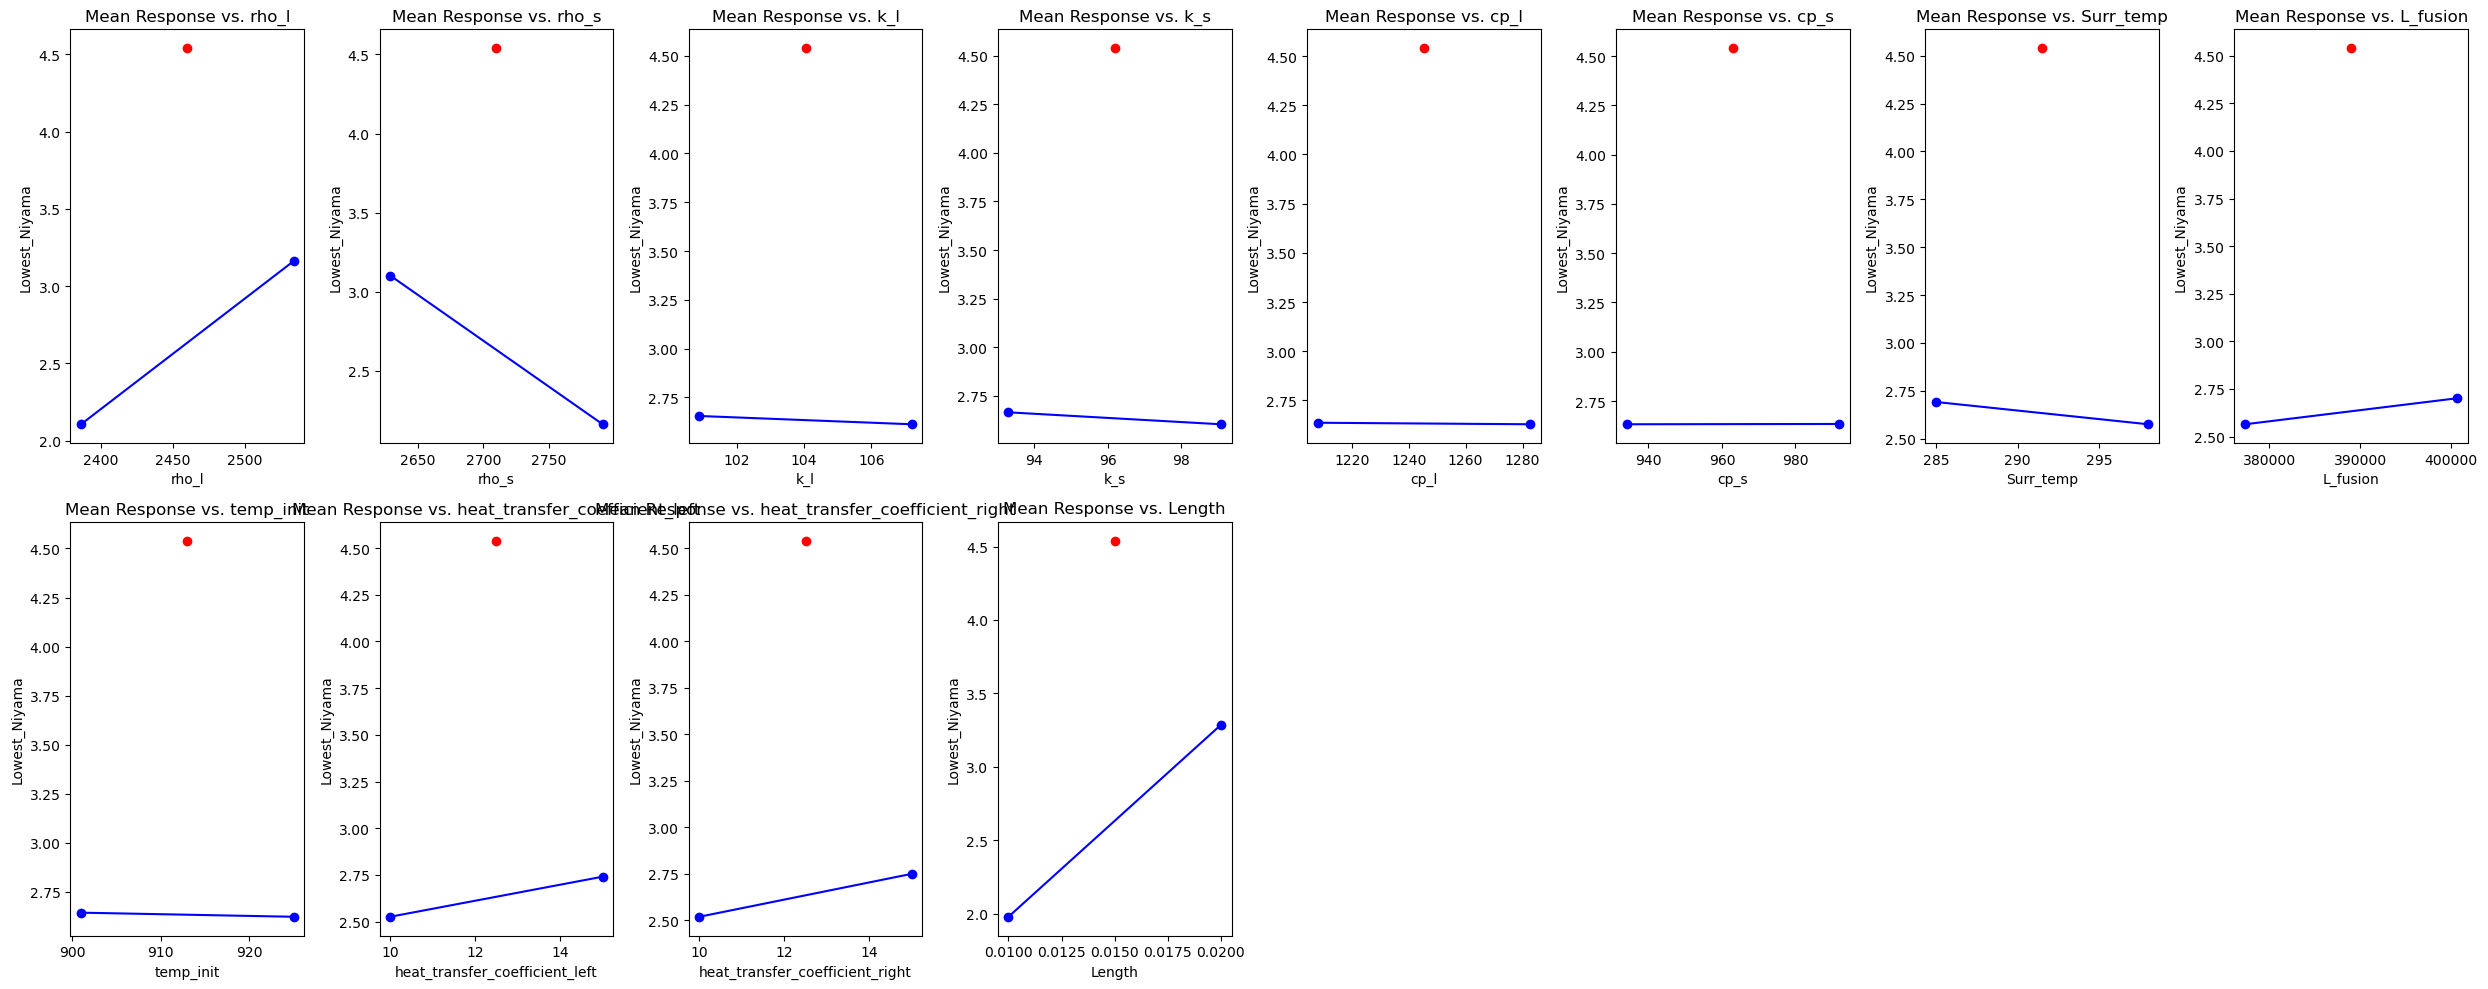

In [296]:
mean_response_center = {}

for factor in factor_names:
    mean_response_center[factor] = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama'].mean()

# print(mean_response_center)
plt.figure(figsize=(25, 10))

for i, factor in enumerate(factor_names):
    plt.subplot(2, 8, i+1)

    mean_responses = mean_response_center[factor]


    center_point = mean_responses.iloc[-2]
    center_point_index = mean_responses.index[-2]
    # print(center_point_index,center)
    non_center_points_low = mean_responses.iloc[0]
    non_center_points_low_index = mean_responses.index[0]
    non_center_points_high = mean_responses.iloc[-1]
    non_center_points_high_index = mean_responses.index[-1]

    plt.plot([non_center_points_low_index,non_center_points_high_index], [non_center_points_low,non_center_points_high],marker='o', color='b')
    
    # Plotting the center points
    center_points = mean_response_center[factor]
    plt.scatter([center_point_index], [center_point], color='r', label='Center Points')
    
    # # Plot all individual data points for the factor
    # all_data_points = Fractional_Factorial_doe_center_pt.groupby(factor)['Lowest_Niyama']
    # for key, group in all_data_points:
    #     plt.scatter([key]*len(group), group, alpha=0.3, color='gray')

    plt.title(f'Mean Response vs. {factor}')
    plt.xlabel(factor)
    plt.ylabel('Lowest_Niyama')

plt.tight_layout()
plt.show()


In [96]:
import statsmodels.api as sm
import pandas as pd
import itertools

# Define the list of variables
variables = ['rho_l', 'rho_s', 'k_l', 'k_s', 'cp_l', 'cp_s', 'Surr_temp', 'L_fusion', 'temp_init', 'heat_transfer_coefficient_left', 'heat_transfer_coefficient_right', 'Length']

# Generate interaction terms
combinations = list(itertools.combinations(variables, 2))
interaction_terms = ['{}*{}'.format(a, b) for a, b in combinations]

# Generate quadratic (axial) terms
quadratic_terms = ['np.power({}, 2)'.format(var) for var in variables]

# Base formula with main effects
base_formula = 'Lowest_Niyama ~ ' + ' + '.join(variables)

# Combine all terms into the final formula
all_terms = variables + interaction_terms + quadratic_terms
final_formula = 'Lowest_Niyama ~ ' + ' + '.join(all_terms)

# Print the final formula
print("Final Formula for Statsmodels:")
print(final_formula)




Final Formula for Statsmodels:
Lowest_Niyama ~ rho_l + rho_s + k_l + k_s + cp_l + cp_s + Surr_temp + L_fusion + temp_init + heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + rho_l*rho_s + rho_l*k_l + rho_l*k_s + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*temp_init + rho_l*heat_transfer_coefficient_left + rho_l*heat_transfer_coefficient_right + rho_l*Length + rho_s*k_l + rho_s*k_s + rho_s*cp_l + rho_s*cp_s + rho_s*Surr_temp + rho_s*L_fusion + rho_s*temp_init + rho_s*heat_transfer_coefficient_left + rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*k_s + k_l*cp_l + k_l*cp_s + k_l*Surr_temp + k_l*L_fusion + k_l*temp_init + k_l*heat_transfer_coefficient_left + k_l*heat_transfer_coefficient_right + k_l*Length + k_s*cp_l + k_s*cp_s + k_s*Surr_temp + k_s*L_fusion + k_s*temp_init + k_s*heat_transfer_coefficient_left + k_s*heat_transfer_coefficient_right + k_s*Length + cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*h

## DOE with Axial Points

In [299]:
axial_points = []

alpha = 1.414

# Calculate the midpoint (center) for each factor
factor_centers = {key: (low + high) / 2 for key, (low, high) in factor_levels.items()}

for factor in factor_levels.keys():
    for direction in [-1,1]:
        axial_point = factor_centers.copy()
        low , high = factor_levels[factor]

        if direction == 1:
            axial_point[factor] = factor_centers[factor] + alpha * (high - factor_centers[factor])
        else:
            axial_point[factor] = factor_centers[factor] - alpha * (factor_centers[factor] - low)
        
            axial_points.append(axial_point)
    


axial_df = pd.DataFrame(axial_points, columns=factor_centers.keys())

comb_df = pd.concat([doe_center_pt, axial_df], axis=0)


comb_df['Lowest_Niyama'] = [0.0] * comb_df.shape[0]
print(comb_df.iloc[140:])      

     rho_l   rho_s     k_l     k_s      cp_l   cp_s  Surr_temp  L_fusion  \
11  2460.0  2710.0  104.04  96.195  1245.295  963.0      291.5  389000.0   

    temp_init  heat_transfer_coefficient_left  \
11      913.0                            12.5   

    heat_transfer_coefficient_right   Length  Lowest_Niyama  
11                             12.5  0.00793            0.0  


In [300]:
counter = 0
for i in range(comb_df.shape[0]):
    input_values = comb_df.iloc[i,:-1].values
    k = sim1d(*input_values)
    comb_df.at[i, 'Lowest_Niyama'] = k
    counter = counter + 1
    print(counter)

print(comb_df.shape)

(23531, 48)
Lowest Niyama:2.94, rho_l:2386.2, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:10.0,htc_r:10.0,length:0.01
1
(21428, 48)
Lowest Niyama:1.61, rho_l:2533.8, rho_s:2628.7, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:15.0,htc_r:10.0,length:0.01
2
(20116, 48)
Lowest Niyama:0.39, rho_l:2386.2, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:925.0,htc_l:10.0,htc_r:15.0,length:0.01
3
(15933, 48)
Lowest Niyama:3.38, rho_l:2533.8, rho_s:2791.3, k_l:100.88, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:377330.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.01
4
(8431, 48)
Lowest Niyama:6.21, rho_l:2386.2, rho_s:2628.7, k_l:107.2, k_s:93.31, cp_l:1207.94, cp_s:934.11, t_surr:285.0, L_fusion:400670.0, temp_init:901.0,htc_l:15.0,htc_r:15.0,length:0.02
5
(10353, 48)
Lowest Niyama:0

### Study of interaction and quadratic effects


In [304]:
formula11 = 'Lowest_Niyama ~ rho_l + rho_s + k_l + k_s \
             + cp_l + cp_s + Surr_temp + L_fusion + temp_init + \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
            rho_l*rho_s + rho_l*k_l + rho_l*cp_l + rho_l*cp_s + rho_l*Surr_temp + rho_l*L_fusion + rho_l*heat_transfer_coefficient_left + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
            rho_s*cp_s + rho_s*Surr_temp + rho_s*L_fusion  + rho_s*heat_transfer_coefficient_left + \
            rho_s*heat_transfer_coefficient_right + rho_s*Length + k_l*cp_l  + k_l*Surr_temp + k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + k_l*Length + k_s*cp_l  + \
            k_s*Surr_temp + k_s*heat_transfer_coefficient_left +  \
            cp_l*cp_s + cp_l*Surr_temp + cp_l*L_fusion + cp_l*temp_init + cp_l*heat_transfer_coefficient_left + \
            cp_l*Length +  cp_s*L_fusion + cp_s*temp_init + cp_s*heat_transfer_coefficient_left + cp_s*heat_transfer_coefficient_right + \
            cp_s*Length + Surr_temp*L_fusion + Surr_temp*temp_init + Surr_temp*heat_transfer_coefficient_left +  \
            Surr_temp*Length + L_fusion*heat_transfer_coefficient_left + L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
            heat_transfer_coefficient_left*Length + heat_transfer_coefficient_right*Length + np.power(rho_l, 2) + np.power(rho_s, 2) + np.power(k_l, 2) + np.power(k_s, 2) + np.power(cp_l, 2) + np.power(cp_s, 2) + np.power(Surr_temp, 2) + np.power(L_fusion, 2) + np.power(temp_init, 2) + np.power(heat_transfer_coefficient_left, 2) + np.power(heat_transfer_coefficient_right, 2) + np.power(Length, 2)'

In [305]:
print(comb_df.shape)
model10 = sm.OLS.from_formula(formula11, data=comb_df).fit()

# Print the model summary
print(model10.summary())

(153, 13)
                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.837
Model:                            OLS   Adj. R-squared:                  0.731
Method:                 Least Squares   F-statistic:                     7.921
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           3.16e-17
Time:                        10:49:43   Log-Likelihood:                -214.59
No. Observations:                 141   AIC:                             541.2
Df Residuals:                      85   BIC:                             706.3
Df Model:                          55                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------

In [306]:
# Extracting coefficients (terms) and their p-values
terms = model10.params.index
coefficients = model10.params.values
p_values = model10.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.9
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] > p_value_threshold]
print(significant_terms)  

                                        Term   P-Value
17                           rho_l:Surr_temp  0.905384
23                                rho_s:cp_s  0.972891
24                           rho_s:Surr_temp  0.913766
27     rho_s:heat_transfer_coefficient_right  0.948347
30                             k_l:Surr_temp  0.980580
35                             k_s:Surr_temp  0.993812
38                            cp_l:Surr_temp  0.985504
42                               cp_l:Length  0.905574
48                        Surr_temp:L_fusion  0.976084
49                       Surr_temp:temp_init  0.986949
50  Surr_temp:heat_transfer_coefficient_left  0.977060


In [383]:
formula12 = 'Lowest_Niyama ~ k_l + k_s \
             + cp_s +  \
            heat_transfer_coefficient_left + heat_transfer_coefficient_right + Length + \
             rho_l*k_l + rho_l*cp_l + rho_l*cp_s + \
             + rho_l*Length + rho_s*k_l + rho_s*cp_l + \
             rho_s*L_fusion  + \
          k_l*L_fusion +\
             + k_l*heat_transfer_coefficient_left  + \
             k_s*heat_transfer_coefficient_left +  \
            cp_l*temp_init +  \
              cp_s*heat_transfer_coefficient_right + \
              L_fusion*heat_transfer_coefficient_left + L_fusion*heat_transfer_coefficient_right + L_fusion*Length + \
            + heat_transfer_coefficient_left*heat_transfer_coefficient_right + \
              np.power(cp_l, 2) + np.power(cp_s, 2) +  np.power(L_fusion, 2) \
                + np.power(heat_transfer_coefficient_left, 2) + \
                  np.power(heat_transfer_coefficient_right, 2) '

In [384]:
model11 = sm.OLS.from_formula(formula12, data=comb_df).fit()

# Print the model summary
print(model11.summary())

                            OLS Regression Results                            
Dep. Variable:          Lowest_Niyama   R-squared:                       0.810
Model:                            OLS   Adj. R-squared:                  0.769
Method:                 Least Squares   F-statistic:                     19.64
Date:                Mon, 16 Sep 2024   Prob (F-statistic):           1.20e-30
Time:                        11:04:36   Log-Likelihood:                -225.21
No. Observations:                 141   AIC:                             502.4
Df Residuals:                     115   BIC:                             579.1
Df Model:                          25                                         
Covariance Type:            nonrobust                                         
                                                                     coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------

In [388]:
# Extracting coefficients (terms) and their p-values
terms = model11.params.index
coefficients = model11.params.values
p_values = model11.pvalues.values

# Combine terms, coefficients, and p-values into a DataFrame
terms_pvalues_df = pd.DataFrame({
    'Term': terms,
    
    'P-Value': p_values
})
# print(terms_pvalues_df)
p_value_threshold = 0.05
significant_terms = terms_pvalues_df.loc[terms_pvalues_df['P-Value'] < p_value_threshold]
print(significant_terms)  

                                                 Term       P-Value
0                                           Intercept  3.084927e-02
2                                                 k_s  1.994927e-02
4                      heat_transfer_coefficient_left  1.468934e-02
5                     heat_transfer_coefficient_right  3.157698e-02
6                                              Length  1.727556e-02
8                                           rho_l:k_l  4.425800e-03
10                                         rho_l:cp_l  1.052178e-02
11                                         rho_l:cp_s  1.674480e-02
12                                       rho_l:Length  2.091381e-02
14                                          rho_s:k_l  1.128692e-02
15                                         rho_s:cp_l  8.782142e-04
17                                     rho_s:L_fusion  4.029978e-03
18                                       k_l:L_fusion  2.803047e-02
19                 k_l:heat_transfer_coefficient

In [390]:
resid66 = model11.resid


In [391]:
from scipy.stats import shapiro

# Shapiro-Wilk Test
stat, p_value = shapiro(resid66)
print('Shapiro-Wilk Test Statistic:', stat)
print('p-value:', p_value)

if p_value > 0.05:
    print('The residuals are normally distributed (fail to reject H0).')
else:
    print('The residuals are not normally distributed (reject H0).')

Shapiro-Wilk Test Statistic: 0.9757846830153404
p-value: 0.013169609804095607
The residuals are not normally distributed (reject H0).


In [392]:
anova_table = sm.stats.anova_lm(model11, typ=2)
print(anova_table)

                                                        sum_sq     df  \
k_l                                                  19.750504    1.0   
k_s                                                   0.105279    1.0   
cp_s                                                 17.060920    1.0   
heat_transfer_coefficient_left                        0.248134    1.0   
heat_transfer_coefficient_right                       2.235353    1.0   
Length                                                1.819203    1.0   
rho_l                                                36.069913    1.0   
rho_l:k_l                                            14.764557    1.0   
cp_l                                                  0.220973    1.0   
rho_l:cp_l                                           11.846935    1.0   
rho_l:cp_s                                           10.322553    1.0   
rho_l:Length                                          9.604521    1.0   
rho_s                                              

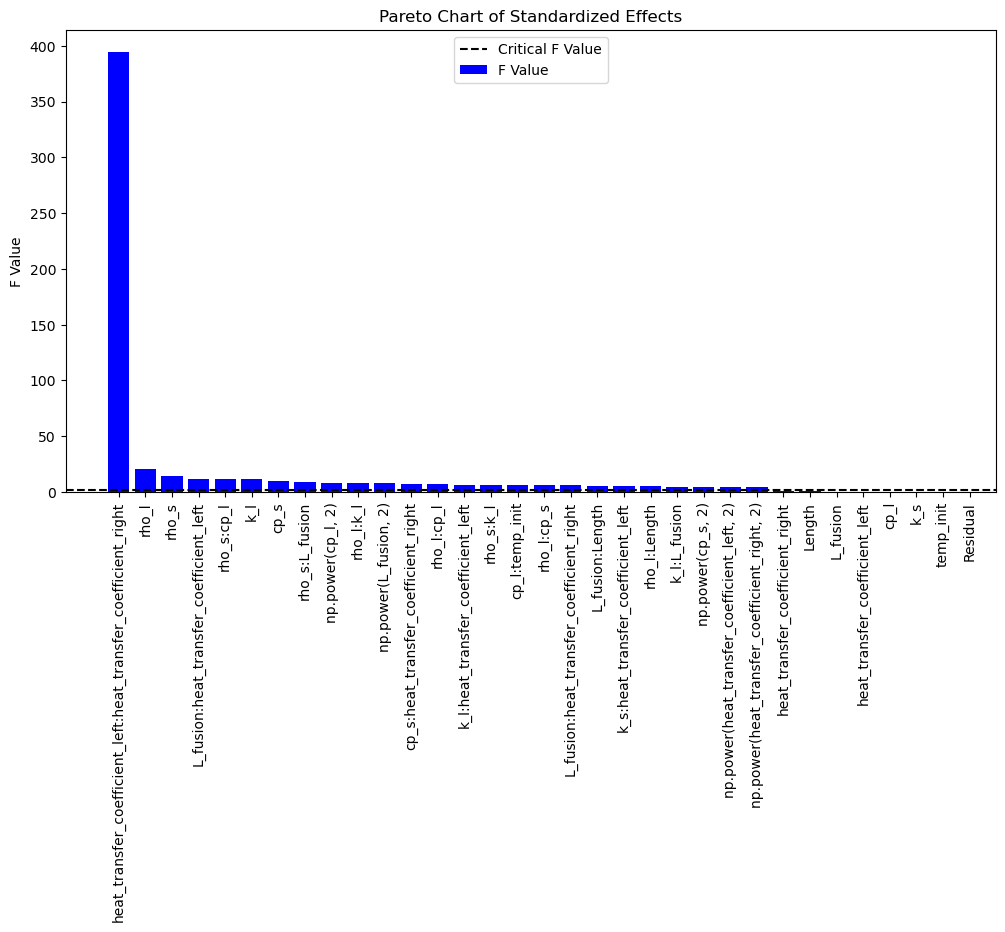

In [395]:
# Pareto Plot from anova_table

# Extract the F-statistic and p-value from the ANOVA table
f_statistic = anova_table['F'].values
p_values = anova_table['PR(>F)'].values

# Calculate the critical F-value
alpha = 0.05
num_total_points = comb_df.shape[0]
num_terms = len(p_values)
critical_f_value = stats.f.ppf(q=1-alpha, dfn=num_terms, dfd=num_total_points-num_terms)

# Create a DataFrame for the Pareto plot
pareto_df = pd.DataFrame({
    'Term': anova_table.index,
    'F Value': f_statistic,
    'P Value': p_values
})

# Sort the DataFrame by the absolute F-value in descending order
pareto_df = pareto_df.reindex(pareto_df['F Value'].abs().sort_values(ascending=False).index)

# Calculate the cumulative sum of the F-values
pareto_df['Cumulative F Value'] = pareto_df['F Value'].cumsum()

# Create a mask for the significant terms
significant_mask = pareto_df['P Value'] < alpha

# Plot the Pareto chart
plt.figure(figsize=(12, 6))
plt.bar(pareto_df['Term'], pareto_df['F Value'], color='b', label='F Value')
plt.axhline(critical_f_value, color='k', linestyle='--', label='Critical F Value')
plt.xticks(rotation=90)
plt.legend()
plt.title('Pareto Chart of Standardized Effects')
plt.ylabel('F Value')
plt.show()




